# Requirements

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np 
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Add as many imports as you need.

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

In [1]:
!gdown 1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC # Download the dataset.

Downloading...
From: https://drive.google.com/uc?id=1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC
To: /content/climate-data.csv
100% 78.1k/78.1k [00:00<00:00, 2.69MB/s]


## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [10]:
# Write your code here. Add as many boxes as you need.
df = pd.read_csv("climate-data.csv")
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


Explore the dataset using visualizations of your choice.

In [11]:
df_copy = df.copy()

In [17]:
df_copy.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [18]:
df_copy.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [27]:
df = df.set_index(['date'])

In [30]:
df = df.sort_index()

In [31]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


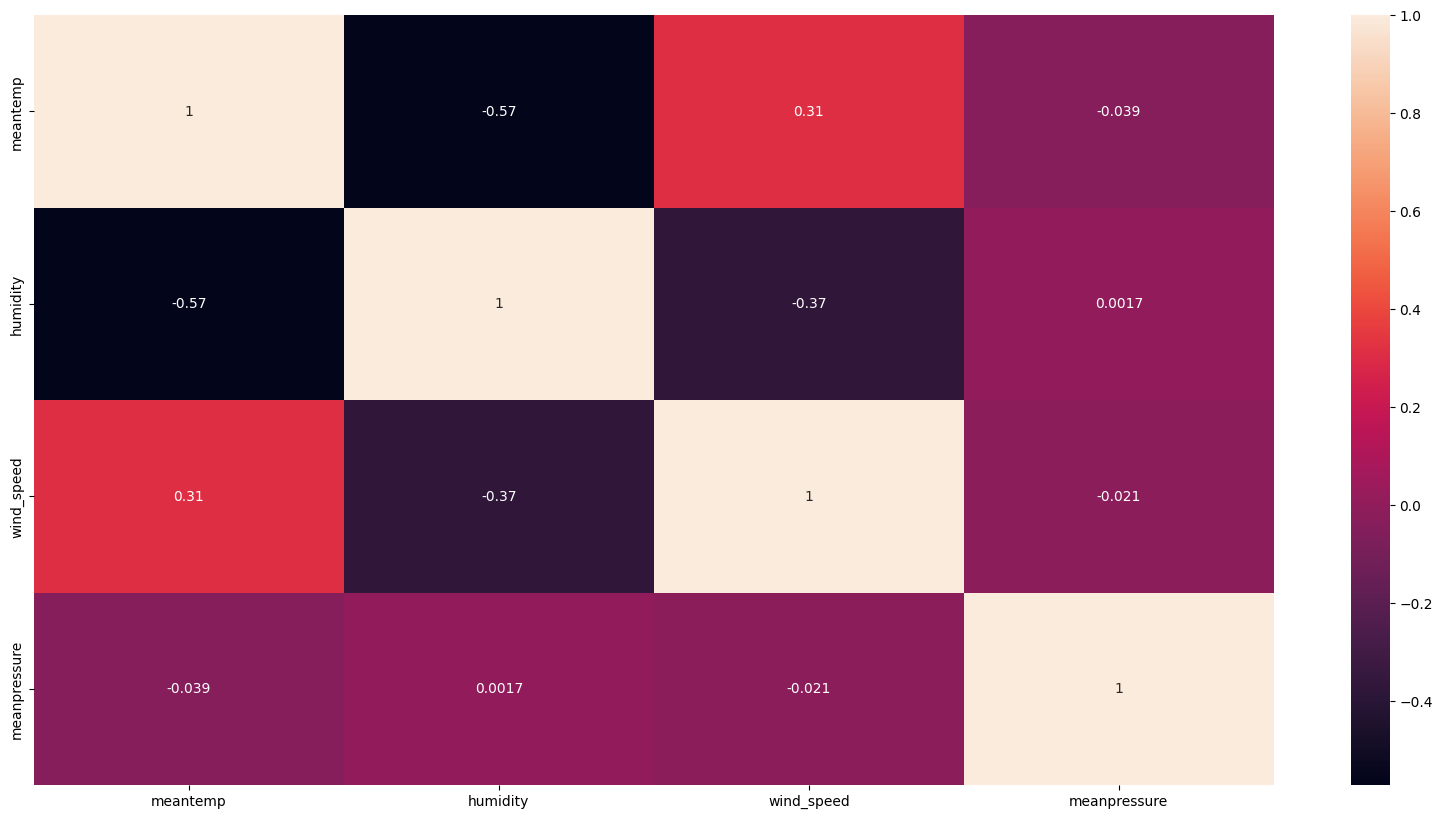

In [32]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
# Write your code here. Add as many boxes as you need.

# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [34]:
lag = 3
for i in range(1, lag + 1):
    df_copy[f'meantemp_prev_{i}'] = df_copy['meantemp'].shift(i)
    df_copy[f'humidity_prev_{i}'] = df_copy['humidity'].shift(i)
    df_copy[f'wind_speed_prev_{i}'] = df_copy['wind_speed'].shift(i)
    df_copy[f'meanpressure_prev_{i}'] = df_copy['meanpressure'].shift(i)

In [37]:
df_copy = df_copy.dropna(axis=0)

In [38]:
df_copy

,meantemp,humidity,wind_speed,meanpressure,meantemp_prev_1,humidity_prev_1,wind_speed_prev_1,meanpressure_prev_1,meantemp_prev_2,humidity_prev_2,wind_speed_prev_2,meanpressure_prev_2,meantemp_prev_3,humidity_prev_3,wind_speed_prev_3,meanpressure_prev_3
date,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000,10.000000,84.500000,0.000000,1015.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667
2013-01-07,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381,14.000000,94.300000,9.085000,1014.350000
2016-12-29,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381
2016-12-30,14.095238,89.666667,6.266667,1017.904762,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000


In [ ]:
feature = ['meantemp_prev_1', 'humidity_prev_1', 'wind_speed_prev_1', 'meanpressure_prev_1', 'meantemp_prev_2', 'humidity_prev_2', 'wind_speed_prev_2', 'meanpressure_prev_2', 'meantemp_prev_3', 'humidity_prev_3', 'wind_speed_prev_3', 'meanpressure_prev_3']

In [85]:
X = df_copy[['meantemp_prev_1', 'humidity_prev_1', 'wind_speed_prev_1', 'meanpressure_prev_1', 'meantemp_prev_2', 'humidity_prev_2', 'wind_speed_prev_2', 'meanpressure_prev_2', 'meantemp_prev_3', 'humidity_prev_3', 'wind_speed_prev_3', 'meanpressure_prev_3']]
Y = df_copy["meantemp"]

In [86]:
X

,meantemp_prev_1,humidity_prev_1,wind_speed_prev_1,meanpressure_prev_1,meantemp_prev_2,humidity_prev_2,wind_speed_prev_2,meanpressure_prev_2,meantemp_prev_3,humidity_prev_3,wind_speed_prev_3,meanpressure_prev_3
date,,,,,,,,,,,,
2013-01-04,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000,10.000000,84.500000,0.000000,1015.666667
2013-01-05,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667,7.400000,92.000000,2.980000,1017.800000
2013-01-06,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667,7.166667,87.000000,4.633333,1018.666667
2013-01-07,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000,8.666667,71.333333,1.233333,1017.166667
2013-01-08,7.000000,78.600000,6.300000,1020.000000,7.000000,82.800000,1.480000,1018.000000,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381,14.000000,94.300000,9.085000,1014.350000
2016-12-29,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000,17.142857,74.857143,8.784211,1016.952381
2016-12-30,15.238095,87.857143,6.000000,1016.904762,17.217391,68.043478,3.547826,1015.565217,16.850000,67.550000,8.335000,1017.200000


In [87]:
Y

date
2013-01-04     8.666667
2013-01-05     6.000000
2013-01-06     7.000000
2013-01-07     7.000000
2013-01-08     8.857143
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1459, dtype: float64

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [88]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,shuffle=False)

In [89]:
rfr = RandomForestRegressor()
rfr.fit(x_train,y_train)

RandomForestRegressor()

In [90]:
y_pred = rfr.predict(x_test)

In [94]:
mse2 = mean_squared_error(y_test,y_pred)
mse2

np.float64(3.065029021526037)

In [95]:
rmse2 = np.sqrt(mse2)
rmse2

np.float64(1.7507224284637577)

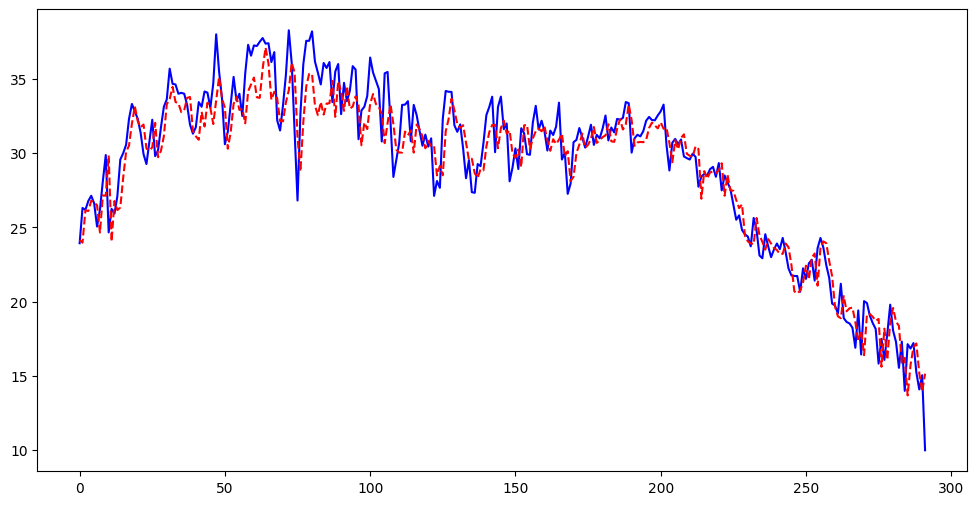

In [96]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, color='blue')
plt.plot(y_pred, color='red', linestyle='--') 
plt.show()

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [97]:
# Write your code here. Add as many boxes as you need.
xgb = XGBRegressor() 
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [98]:
# Write your code here. Add as many boxes as you need.
y2_pred = xgb.predict(x_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

In [100]:
mse2 = mean_squared_error(y_test,y2_pred)
mse2

np.float64(4.061991489304081)

In [101]:
rmse2 = np.sqrt(mse2)
rmse2

np.float64(2.0154382871485)

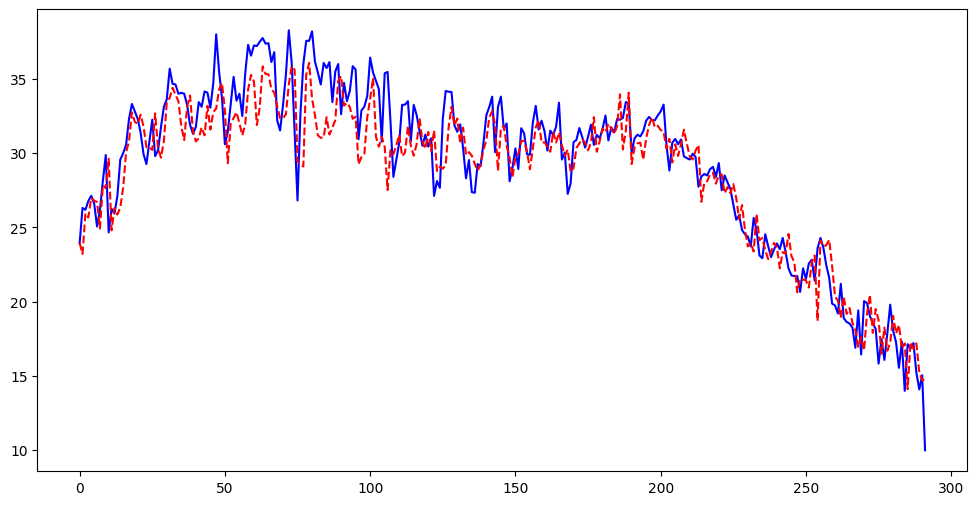

In [102]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, color='blue')
plt.plot(y2_pred, color='red', linestyle='--') 
plt.show()

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [ ]:
# Write your code here. Add as many boxes as you need.

Use the trained model to make predictions for the test set.

In [ ]:
# Write your code here. Add as many boxes as you need.

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [104]:
!pip install keras

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.2 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.2 MB ? eta -:--:--
   ---------------------------------- ----- 1.0/1.2 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.8/3.0 MB 4.8 MB/s eta 0:00:01
   --------------------- ------------------ 1.6/3.0 MB 4.0 MB/s eta 0:00:01
   ----------------------------------- ---- 2.6/3.0 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 3.9 MB/s eta 0:00:00


In [105]:
!pip install tensorflow

   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/390.3 MB 3.4 MB/s eta 0:01:56
   ---------------------------------------- 1.3/390.3 MB 3.4 MB/s eta 0:01:56
   ---------------------------------------- 2.1/390.3 MB 3.6 MB/s eta 0:01:50
   ---------------------------------------- 2.9/390.3 MB 3.7 MB/s eta 0:01:44
   ---------------------------------------- 3.7/390.3 MB 3.8 MB/s eta 0:01:42
   ---------------------------------------- 4.7/390.3 MB 3.9 MB/s eta 0:01:39
    --------------------------------------- 5.5/390.3 MB 3.9 MB/s eta 0:01:39
    --------------------------------------- 6.6/390.3 MB 3.9 MB/s eta 0:01:38
    --------------------------------------- 7.3/390.3 MB 4.0 MB/s eta 0:01:36
    --------------------------------------- 8.4/390.3 MB 4.1 MB/s eta 0:01:34
    --------------------------------------- 9.2/390.3 MB 4.1 MB/s eta 0:01:34
   - -------------------------------------- 10.2/390.3 MB 4.1 MB/s eta 

  You can safely remove it manually.
  You can safely remove it manually.


In [106]:
from keras import Sequential

In [108]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [119]:
from sklearn.preprocessing import LabelEncoder

enc=LabelEncoder()
for column in df.columns:
    df[column] = enc.fit_transform(df[column].to_numpy().reshape(-1,1))

C:\Users\User\miniconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\miniconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\miniconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\miniconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

In [120]:
X= df.iloc[:,1:]
Y= df['meantemp']

In [121]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

In [122]:
model = Sequential()

In [123]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 2014-01-31 to 2016-08-15
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   humidity      1096 non-null   int64
 1   wind_speed    1096 non-null   int64
 2   meanpressure  1096 non-null   int64
dtypes: int64(3)
memory usage: 34.2+ KB


In [113]:
from keras.layers import Dense
from keras.api.layers import LSTM, Dense, Dropout

In [114]:
model = Sequential()
model.add(LSTM(100,  activation='relu', input_shape=(x_train_scaled_shaped.shape[1], x_train_scaled_shaped.shape[2]), return_sequences=True))
model.add(LSTM(50,  activation='relu'))
model.add(Dense(1, activation='linear'))

NameError: name 'x_train_scaled_shaped' is not defined